# HCB Method with Intrusive Order Reduction

This prototype includes: 
- Domain Decomposition (substructuring) 
- Intrusive model order reduction via eigenmode truncation 

This prototype excludes: 
- Randomness of the system 
- Generalisation for more than two substructures

As illustration, consider a simple longitudinal beam with total length of $1$ modelled with FE model with the following mass matrix, with $\Delta L$ being the length of each element: 

\begin{equation*}
    \mathbf{M} = 
    \Delta L \cdot 
    \begin{bmatrix}
        1 & 0 & 0 & \dots & 0 & 0 & 0 \\
        0 & 2 & 0 & \dots & 0 & 0 & 0 \\ 
        0 & 0 & 2 & \dots & 0 & 0 & 0 \\
        \vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots \\
        0 & 0 & 0 & \dots & 2 & 0 & 0 \\
        0 & 0 & 0 & \dots & 0 & 2 & 0 \\ 
        0 & 0 & 0 & \dots & 0 & 0 & 1 
    \end{bmatrix}
\end{equation*}

The stiffness matrix takes the following form: 

\begin{equation*}
    \mathbf{K} = 
    \frac{100}{\Delta L} \cdot 
    \begin{bmatrix}
        1 & -1 & 0 & \dots & 0 & 0 & 0 \\
        -1 & 2 & -1 & \dots & 0 & 0 & 0 \\ 
        0 & -1 & 2 & \dots & 0 & 0 & 0 \\
        \vdots & \vdots & \ddots & \ddots & \ddots & \vdots & \vdots \\
        0 & 0 & 0 & \dots & 2 & -1 & 0 \\
        0 & 0 & 0 & \dots & -1 & 2 & -1 \\ 
        0 & 0 & 0 & \dots & 0 & -1 & 1 
    \end{bmatrix}
\end{equation*}

For simplicity, the uniform load vector is used: 

\begin{equation*}
    \mathbf{f} =
    \Delta L \cdot 
    \begin{bmatrix}
        1 & 1 & \dots & 1 & 1
    \end{bmatrix}^{T}
\end{equation*}

The beam is divided into two substructures of equal length. In addition, a homogenous dirichlet boundary condition is applied to the last node.

### Preamble

In [42]:
import numpy as np 
from scipy.linalg import sqrtm 
import matplotlib.pyplot as plt 

omega = 60.0

l1 = 0.5 
l2 = 0.5 

l = l1 + l2 

# Set number of nodes in substructure 1 and 2 
n_1 = 160 
n_2 = 160 

# Set size of reduced matrix for substructure 1 and 2 
m_1 = 8
m_2 = 8

# Computations 

## Compute Matrices of Each Substructure

Matrices and vectors of each substructure are computed independently and in parallel 

### Substructure 1 

The following computations are performed independently on computer 1 

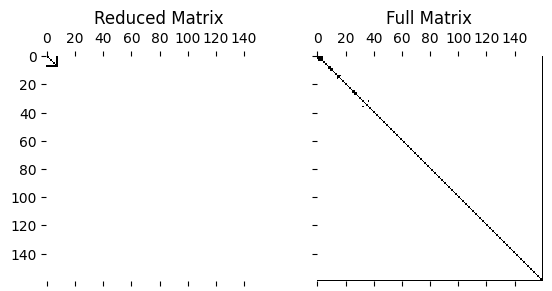

In [43]:
# Assemble mass & stiffness matrices and load vector 

dl1 = l1 / (n_1-1) 

main_diagonal = np.ones( n_1 )
subdiagonal   = np.ones( n_1 - 1 ) 

M_1 = np.zeros( (n_1,n_1) )
M_1 += np.diag( 2 * main_diagonal ) 
M_1[0,0] = 1
M_1[n_1-1,n_1-1] = 1

K_1 = np.zeros( (n_1,n_1) ) 
K_1 += np.diag( 200 * main_diagonal ) 
K_1[0,0] = 100 
K_1[n_1-1,n_1-1] = 100 
K_1 += np.diag( -100 * subdiagonal, k =  1 )
K_1 += np.diag( -100 * subdiagonal, k = -1 )

f_1 = np.reshape( main_diagonal, (n_1,1) ) 

M_1 = 1 * dl1 * M_1
K_1 = 1 / dl1 * K_1 
f_1 = 1 * dl1 * f_1 

# Compute internal modes with boundary node (last node) fixed 

M_II_1 = M_1[0:n_1-1,0:n_1-1] 
K_II_1 = K_1[0:n_1-1,0:n_1-1] 

eigenvalues, Phi_N_1 = np.linalg.eig( np.linalg.solve( M_II_1, K_II_1 ) )

# Sort eigenvectors with increasing eigenvalues and only keep the first m_1 modes

# Only to compare resulting matrix later on
Phi_N_1_Full = Phi_N_1 

sorted_indices = np.argsort( eigenvalues ) 
Phi_N_1 = Phi_N_1[:,sorted_indices]
Phi_N_1 = Phi_N_1[:,0:m_1-1]

# Use mass - normalised eigenmodes 

Phi_N_1 = np.transpose( np.linalg.solve( 
    sqrtm( (np.transpose(Phi_N_1) @ M_II_1 @ Phi_N_1)  ), 
    np.transpose(Phi_N_1) 
)) 

# Compute boundary mode

K_IB_1 = K_1[0:n_1-1,n_1-1] 

Phi_C_1 = - np.reshape( np.linalg.solve( K_II_1, K_IB_1 ), (n_1-1,1) ) 

# Compute transformation matrix 

I = np.eye( Phi_C_1.shape[1] )
O = np.zeros( (I.shape[0], Phi_N_1.shape[1]) )

G_1 = np.vstack(( np.hstack( (Phi_N_1, Phi_C_1) ),
                  np.hstack( (      O,       I) )))

# Only to compare resulting matrix later on 
O_Full = np.zeros( (I.shape[0], Phi_N_1_Full.shape[1]) )

G_1_Full = np.vstack(( np.hstack( (Phi_N_1_Full, Phi_C_1) ),
                       np.hstack( (      O_Full,       I) )))

# Compute modal system of equations 

D_1 = np.transpose(G_1) @ ( K_1 - omega * omega * M_1 ) @ G_1 

# Only to compare resulting matrix later on 
D_1_Full = np.transpose(G_1_Full) @ ( K_1 - omega * omega * M_1 ) @ G_1_Full 

# Compare sparsity pattern between full and reduced system 

tolerance = 1e-8
D_modified = np.abs(D_1) > tolerance
D_modified_Full = np.abs(D_1_Full) > tolerance

fix, axes = plt.subplots( 
    nrows = 1, ncols = 2, 
    sharex = True, 
    sharey = True
) 

axes[0].spy(D_modified     ) 
axes[0].set_title('Reduced Matrix')

axes[1].spy(D_modified_Full) 
axes[1].set_title('Full Matrix')

for ax in axes: 

    ax.spines['top'].set_visible( False ) 
    ax.spines['right'].set_visible( False ) 
    ax.spines['bottom'].set_visible( False ) 
    ax.spines['left'].set_visible( False ) 

plt.show() 

# Compute Schur complement matrix 

D_NN_1 = D_1[0:m_1-1,0:m_1-1] 
D_NC_1 = D_1[0:m_1-1,m_1-1] 
D_CN_1 = D_1[m_1-1,0:m_1-1] 
D_CC_1 = D_1[m_1-1,m_1-1] 

S_1 = D_CC_1 - D_CN_1 @ np.linalg.solve( D_NN_1, D_NC_1 ) 

# Compute load vector 

F_1 = np.transpose(G_1) @ f_1 

F_N_1 = F_1[0:m_1-1,0] 
F_C_1 = F_1[m_1-1,0] 

P_1 = F_C_1 - D_CN_1 @ np.linalg.solve( D_NN_1, F_N_1 ) 

# Send S_1 and P_1 to central computer to calculate u_C 

### Substructure 2 

The following computations are performed independently on computer 2 

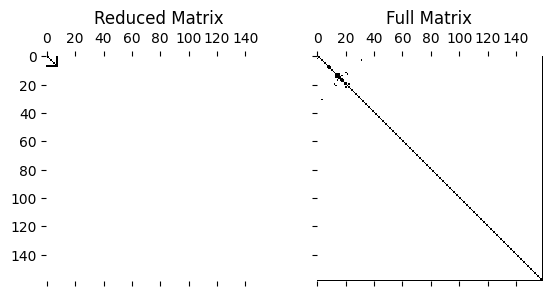

In [44]:
# Assemble mass & stiffness matrix and load vector 

dl2 = l2 / ( n_2 - 1 ) 

main_diagonal = np.ones( n_2 )
subdiagonal   = np.ones( n_2 - 1 ) 

M_2 = np.zeros( (n_2,n_2) )
M_2 += np.diag( 2 * main_diagonal ) 
M_2[0,0] = 1
M_2[n_2-1,n_2-1] = 1

K_2 = np.zeros( (n_2,n_2) ) 
K_2 += np.diag( 200 * main_diagonal ) 
K_2[0,0] = 100
K_2[n_2-1,n_2-1] = 100
K_2 += np.diag( -100 * subdiagonal, k =  1 )
K_2 += np.diag( -100 * subdiagonal, k = -1 )

f_2 = np.reshape( main_diagonal, (n_2,1) ) 

M_2 = 1 * dl2 * M_2 
K_2 = 1 / dl2 * K_2
f_2 = 1 * dl2 * f_2 

# Apply boundary condition to the last node 

M_2[0:n_2-1,n_2-1] = 0 
M_2[n_2-1,0:n_2-1] = 0 
M_2[n_2-1,n_2-1]   = 1 

K_2[0:n_2-1,n_2-1] = 0 
K_2[n_2-1,0:n_2-1] = 0 
K_2[n_2-1,n_2-1]   = 1 

f_2[0,0] = 0 
f_2[n_2-1,0] = 0 

# Rearrange matrix's rows and columns so boundary node is at the end 

M_2 = np.concatenate( (M_2[1:], [M_2[0]]) ) 
M_2 = np.concatenate( (M_2[:,1:], np.reshape(M_2[:,0],(n_2,1))), axis=1 ) 

K_2 = np.concatenate( (K_2[1:], [K_2[0]]) ) 
K_2 = np.concatenate( (K_2[:,1:], np.reshape(K_2[:,0],(n_2,1))), axis=1 ) 

f_2 = np.concatenate( (f_2[1:], [f_2[0]]) ) 

# compute internal mode with boundary node and clamped nodes fixed 

M_II_2 = M_2[0:n_2-2,0:n_2-2]
K_II_2 = K_2[0:n_2-2,0:n_2-2]


eigenvalues, Phi_N_2 = np.linalg.eig( np.linalg.solve( M_II_2, K_II_2 ) )

# Sort eigenvectors with increasing eigenvalues and only keep the first m_2 modes 

# Only to compare resulting matrix later on 
Phi_N_2_Full = Phi_N_2 
Phi_N_2_Full = np.pad(Phi_N_2_Full,((0,1),(0,0)))

sorted_indices = np.argsort( eigenvalues ) 
Phi_N_2 = Phi_N_2[:,sorted_indices]
Phi_N_2 = Phi_N_2[:,0:m_2-1]

# use mass - normalised eigenmodes 

Phi_N_2 = np.transpose( np.linalg.solve( 
    sqrtm( (np.transpose(Phi_N_2) @ M_II_2 @ Phi_N_2) ), 
    np.transpose(Phi_N_2) 
)) 

Phi_N_2 = np.pad(Phi_N_2,((0,1),(0,0)))

# Compute boundary mode

K_IB_2 = K_2[0:n_2-1,n_2-1]
K_II_2 = K_2[0:n_2-1,0:n_2-1]

Phi_C_2 = - np.reshape( np.linalg.solve( K_II_2, K_IB_2 ), (n_2-1,1) )

# Compute transformation matrix 

I = np.eye( Phi_C_2.shape[1] )
O = np.zeros( (I.shape[0], Phi_N_2.shape[1]) )

G_2 = np.vstack(( np.hstack( (Phi_N_2, Phi_C_2) ),
                  np.hstack( (      O,       I) )))

# Only to compare resulting matrix later on 
O_Full = np.zeros( (I.shape[0], Phi_N_2_Full.shape[1]) )

G_2_Full = np.vstack(( np.hstack( (Phi_N_2_Full, Phi_C_2) ),
                       np.hstack( (      O_Full,       I) )))

# Compute modal system of equations 

D_2 = np.transpose(G_2) @ ( K_2 - omega * omega * M_2 ) @ G_2 

# Only to compare resulting matrix later on 
D_2_Full = np.transpose(G_2_Full) @ ( K_2 - omega * omega * M_2 ) @ G_2_Full 

# Compare sparsity pattern between full and reduced system 

tolerance = 1e-8 
D_modified = np.abs(D_2) > tolerance
D_modified_Full = np.abs(D_2_Full) > tolerance

fix, axes = plt.subplots( 
    nrows = 1, ncols = 2, 
    sharex = True, 
    sharey = True
) 

axes[0].spy(D_modified     ) 
axes[0].set_title('Reduced Matrix')

axes[1].spy(D_modified_Full) 
axes[1].set_title('Full Matrix')

for ax in axes: 

    ax.spines['top'].set_visible( False ) 
    ax.spines['right'].set_visible( False ) 
    ax.spines['bottom'].set_visible( False ) 
    ax.spines['left'].set_visible( False ) 

plt.show() 

# Compute Schur complement matrix 

D_NN_2 = D_2[0:m_2-1,0:m_2-1] 
D_NC_2 = D_2[0:m_2-1,m_2-1] 
D_CN_2 = D_2[m_2-1,0:m_2-1] 
D_CC_2 = D_2[m_2-1,m_2-1]

S_2 =  D_CC_2 - D_CN_2 @ np.linalg.solve( D_NN_2, D_NC_2 ) 

# Compute load vector 

F_2 = np.transpose(G_2) @ f_2

F_N_2 = F_2[0:m_2-1,0] 
F_C_2 = F_2[m_2-1,0] 

P_2 = F_C_2 - D_CN_2 @ np.linalg.solve( D_NN_2, F_N_2 ) 

# Send S_2 and P_2 to central computer to calculate u_C 

## Solve Boundary DoF(s)

Matrices and vectors from each substructure are gathered in one central computer and boundary DoF's value is calculated

In [45]:
# Receive S_1 & P_1 from computer 1 
# Receive S_2 & P_2 from computer 2 

u_C = (P_1+P_2) / (S_1+S_2) 

# Send / broadcast u_C to computer 1 and 2 

## Solve Internal DoFs 

Boundary DoF's value is broadcasted to all computers and internal DoFs of each substructure are calculated independently and in parallel 

### Solve for internal mode 1 

The following computations are performed independently on computer 1 

In [46]:
# Receive u_C from central computer 

u_N_1 = np.linalg.solve( D_NN_1, (F_N_1 - u_C * D_NC_1) )

# Transform from modal space to physical space 

u_1 = np.reshape( 
        Phi_N_1 @ u_N_1, (n_1-1,1) 
    ) + np.reshape( 
        u_C * Phi_C_1, (n_1-1,1) 
    )

# Send u_1 to central computer for postprocessing (only if needed) 

### Solve for internal mode 2 

The following computations are performed independently on computer 2 

In [47]:
# Receive u_C from central computer 

u_N_2 = np.linalg.solve( D_NN_2, (F_N_2 - u_C * D_NC_2) )

# Transform from modal space to physical space 

u_2 = np.reshape( 
        Phi_N_2 @ u_N_2, (n_2-1,1) 
    ) + np.reshape( 
        u_C * Phi_C_2, (n_2-1,1) 
    )

# Send u_2 to central computer for postprocessing (only if needed) 

## Postprocessing 

This step is just to compare results obtained from the method with results from solving the full system of equations 

### Gather Solutions 

The following computations are only performed on central computer if all DoF values are needed for postprocessing 

In [48]:
# Receive u_1 from computer 1 (only if needed) 
# Receive u_2 from computer 2 (only if needed) 

u_HCB = np.vstack((np.vstack ((u_1,u_C)),u_2))

### Compare with Full Solution 

The following computations are just performed to compare the result of solving the full system of equations with the result from reduced HCB model

In [49]:
# Assemble full mass & stiffness matrix and load vector 

n = n_1 + n_2 - 1

dl = l / (n-1) 

main_diagonal = np.ones( n )
subdiagonal   = np.ones( n - 1 ) 

M = np.zeros( (n,n) )
M += np.diag( 2 * main_diagonal ) 
M[0,0] = 1
M[n-1,n-1] = 1

K = np.zeros( (n,n) ) 
K += np.diag( 200 * main_diagonal ) 
K[0,0] = 100
K[n-1,n-1] = 100
K += np.diag( -100 * subdiagonal, k =  1 )
K += np.diag( -100 * subdiagonal, k = -1 )

f = np.reshape( main_diagonal, (n,1) ) 

M = 1 * dl * M 
K = 1 / dl * K 
f = 1 * dl * f 

# Apply boundary condition to the last node 

M[0:n-1,n-1] = 0 
M[n-1,0:n-1] = 0 
M[n-1,n-1]   = 1 

K[0:n-1,n-1] = 0 
K[n-1,0:n-1] = 0 
K[n-1,n-1]   = 1 

f[n-1,0] = 0 

# Solve full system of equations

u_F = np.linalg.solve((K - omega * omega * M), f ) 

# Comparison with Full System 

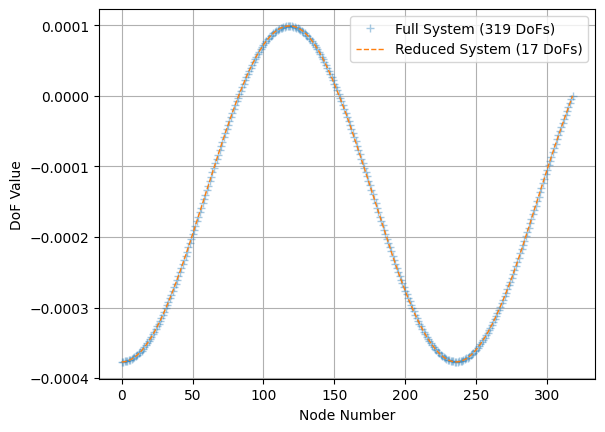

In [52]:
indices = np.arange( len(u_F) ) 

plt.plot( 
    indices, u_F, 
    linestyle = '', 
    marker = '+', 
    alpha = 0.4, 
    label = f'Full System ({n_1+n_2-1} DoFs)' 
) 

plt.plot( 
    indices, u_HCB, 
    linestyle = '--', 
    linewidth = 1.0, 
    marker = '', 
    label = f'Reduced System ({m_1+m_2+1} DoFs)' 
) 

plt.xlabel('Node Number') 
plt.ylabel('DoF Value') 

plt.grid( True ) 
plt.legend() 
plt.show()